In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz

--2022-05-08 03:15:32--  https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.192.192
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.192.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘CUB_200_2011.tgz’

CUB_200_2011.tgz    100%[===================>]   1.07G  48.4MB/s    in 21s     

2022-05-08 03:15:53 (52.7 MB/s) - ‘CUB_200_2011.tgz’ saved [1150585339/1150585339]



In [ ]:
!ls

CUB_200_2011.tgz  drive  sample_data


In [ ]:
import tarfile
tar = tarfile.open("CUB_200_2011.tgz")
tar.extractall()
tar.close()

In [ ]:

"""StackGAN.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pickle
import random
import time

import numpy as np
import pandas as pd
import tensorflow as tf

assert tf.__version__.startswith('2')

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, ReLU, Activation
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Dense, concatenate
from tensorflow.keras.layers import Flatten, Lambda, Reshape, ZeroPadding2D, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# conditioned by the text.
def conditioning_augmentation(x):
	"""The mean_logsigma passed as argument is converted into the text conditioning variable.

	Args:
		x: The output of the text embedding passed through a FC layer with LeakyReLU non-linearity.

	Returns:
	 	c: The text conditioning variable after computation.
	"""
	mean = x[:, :128]
	log_sigma = x[:, 128:]

	stddev = tf.math.exp(log_sigma)
	epsilon = K.random_normal(shape=K.constant((mean.shape[1], ), dtype='int32'))
	c = mean + stddev * epsilon
	return c

def build_ca_network():

	input_layer1 = Input(shape=(1024,)) #size of the vocabulary in the text data
	mls = Dense(256)(input_layer1)
	mls = LeakyReLU(alpha=0.2)(mls)
	ca = Lambda(conditioning_augmentation)(mls)
	return Model(inputs=[input_layer1], outputs=[ca]) 


In [ ]:


def UpSamplingBlock(x, num_kernels):

	x = UpSampling2D(size=(2,2))(x)
	x = Conv2D(num_kernels, kernel_size=(3,3), padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x) 
	x = ReLU()(x)
	return x


def build_stage1_generator():

	input_layer1 = Input(shape=(1024,))
	ca = Dense(256)(input_layer1)
	ca = LeakyReLU(alpha=0.2)(ca)

	# Obtain the conditioned text
	c = Lambda(conditioning_augmentation)(ca)

	input_layer2 = Input(shape=(100,))
	concat = Concatenate(axis=1)([c, input_layer2]) 

	x = Dense(16384, use_bias=False)(concat) 
	x = ReLU()(x)
	x = Reshape((4, 4, 1024), input_shape=(16384,))(x)

	x = UpSamplingBlock(x, 512) 
	x = UpSamplingBlock(x, 256)
	x = UpSamplingBlock(x, 128)
	x = UpSamplingBlock(x, 64)   # upsampled our image to 64*64*3 

	x = Conv2D(3, kernel_size=3, padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = Activation('tanh')(x)

	stage1_gen = Model(inputs=[input_layer1, input_layer2], outputs=[x, ca]) 
	return stage1_gen



In [ ]:
generator = build_stage1_generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          262400      ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256)          0           ['dense[0][0]']                  
                                                                                                  
 lambda (Lambda)                (None, 128)          0           ['leaky_re_lu[0][0]']            
                                                                                              

In [ ]:
def ConvBlock(x, num_kernels, kernel_size=(4,4), strides=2, activation=True):
	"""A ConvBlock with a Conv2D, BatchNormalization and LeakyReLU activation.

	Args:
		x: The preceding layer as input.
		num_kernels: Number of kernels for the Conv2D layer.

	Returns:
		x: The final activation layer after the ConvBlock block.
	"""
	x = Conv2D(num_kernels, kernel_size=kernel_size, padding='same', strides=strides, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	
	if activation:
		x = LeakyReLU(alpha=0.2)(x)
	return x


def build_embedding_compressor():
    """Build embedding compressor model
    """
    input_layer1 = Input(shape=(1024,)) 
    x = Dense(128)(input_layer1)
    x = ReLU()(x)

    model = Model(inputs=[input_layer1], outputs=[x])
    return model

# the discriminator is fed with two inputs, the feature from Generator and the text embedding
def build_stage1_discriminator():
	
	input_layer1 = Input(shape=(64, 64, 3))  

	x = Conv2D(64, kernel_size=(4,4), strides=2, padding='same', use_bias=False,
				kernel_initializer='he_uniform')(input_layer1)
	x = LeakyReLU(alpha=0.2)(x)

	x = ConvBlock(x, 128)
	x = ConvBlock(x, 256)
	x = ConvBlock(x, 512)

	# Obtain the compressed and spatially replicated text embedding
	input_layer2 = Input(shape=(4, 4, 128)) #2nd input to discriminator, text embedding
	concat = concatenate([x, input_layer2])

	x1 = Conv2D(512, kernel_size=(1,1), padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(concat)
	x1 = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x1 = LeakyReLU(alpha=0.2)(x)

	# Flatten and add a FC layer to predict.
	x1 = Flatten()(x1)
	x1 = Dense(1)(x1)
	x1 = Activation('sigmoid')(x1)

	stage1_dis = Model(inputs=[input_layer1, input_layer2], outputs=[x1])  
	return stage1_dis


In [ ]:
discriminator = build_stage1_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 64)   3072        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)      (None, 32, 32, 64)   0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 16, 16, 128)  131072      ['leaky_re_lu_1[0][0]']          
                                                                                            

In [ ]:
# Building GAN with Generator and Discriminator

def build_adversarial(generator_model, discriminator_model):
	
	input_layer1 = Input(shape=(1024,))  
	input_layer2 = Input(shape=(100,)) 
	input_layer3 = Input(shape=(4, 4, 128)) 

	x, ca = generator_model([input_layer1, input_layer2]) #text,noise

	discriminator_model.trainable = False 

	probabilities = discriminator_model([x, input_layer3]) 
	adversarial_model = Model(inputs=[input_layer1, input_layer2, input_layer3], outputs=[probabilities, ca])
	return adversarial_model



In [ ]:
ganstage1 = build_adversarial(generator, discriminator)
ganstage1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 model (Functional)             [(None, 64, 64, 3),  10270400    ['input_5[0][0]',                
                                 (None, 256)]                     'input_6[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, 4, 4, 128)]  0           []                         

In [ ]:

def checkpoint_prefix():
	checkpoint_dir = './training_checkpoints'
	checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

	return checkpoint_prefix

def adversarial_loss(y_true, y_pred):
	mean = y_pred[:, :128]
	ls = y_pred[:, 128:]
	loss = -ls + 0.5 * (-1 + tf.math.exp(2.0 * ls) + tf.math.square(mean))
	loss = K.mean(loss)
	return loss

def normalize(input_image, real_image):
	input_image = (input_image / 127.5) - 1
	real_image = (real_image / 127.5) - 1

	return input_image, real_image

def load_class_ids_filenames(class_id_path, filename_path):
	with open(class_id_path, 'rb') as file:
		class_id = pickle.load(file, encoding='latin1')

	with open(filename_path, 'rb') as file:
		filename = pickle.load(file, encoding='latin1')

	return class_id, filename

def load_text_embeddings(text_embeddings):
	with open(text_embeddings, 'rb') as file:
		embeds = pickle.load(file, encoding='latin1')
		embeds = np.array(embeds)

	return embeds

def load_bbox(data_path):
	bbox_path = data_path + '/bounding_boxes.txt'
	image_path = data_path + '/images.txt'
	bbox_df = pd.read_csv(bbox_path, delim_whitespace=True, header=None).astype(int)
	filename_df = pd.read_csv(image_path, delim_whitespace=True, header=None)

	filenames = filename_df[1].tolist()
	bbox_dict = {i[:-4]:[] for i in filenames[:2]}

	for i in range(0, len(filenames)):
		bbox = bbox_df.iloc[i][1:].tolist()
		dict_key = filenames[i][:-4]
		bbox_dict[dict_key] = bbox

	return bbox_dict

def load_images(image_path, bounding_box, size):
	"""Crops the image to the bounding box and then resizes it.
	"""
	image = Image.open(image_path).convert('RGB')
	w, h = image.size
	if bounding_box is not None:
		r = int(np.maximum(bounding_box[2], bounding_box[3]) * 0.75)
		c_x = int((bounding_box[0] + bounding_box[2]) / 2)
		c_y = int((bounding_box[1] + bounding_box[3]) / 2)
		y1 = np.maximum(0, c_y - r)
		y2 = np.minimum(h, c_y + r)
		x1 = np.maximum(0, c_x - r)
		x2 = np.minimum(w, c_x + r)
		image = image.crop([x1, y1, x2, y2])

	image = image.resize(size, PIL.Image.BILINEAR)
	return image

def load_data(filename_path, class_id_path, dataset_path, embeddings_path, size):
	"""Loads the Dataset.
	"""
	data_dir = "/content/drive/MyDrive/Colab Notebooks/birds"
	train_dir = data_dir + "/train"
	test_dir = data_dir + "/test"
	embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
	embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
	filename_path_train = train_dir + "/filenames.pickle"
	filename_path_test = test_dir + "/filenames.pickle"
	class_id_path_train = train_dir + "/class_info.pickle"
	class_id_path_test = test_dir + "/class_info.pickle"
	dataset_path = "/content/drive/MyDrive/Colab Notebooks/CUB_200_2011"
	class_id, filenames = load_class_ids_filenames(class_id_path, filename_path)
	embeddings = load_text_embeddings(embeddings_path)
	bbox_dict = load_bbox(dataset_path)

	x, y, embeds = [], [], []

	for i, filename in enumerate(filenames):
		bbox = bbox_dict[filename]

		try:	
			image_path = f'{dataset_path}/images/{filename}.jpg'
			image = load_images(image_path, bbox, size)
			e = embeddings[i, :, :]
			embed_index = np.random.randint(0, e.shape[0] - 1)
			embed = e[embed_index, :]

			x.append(np.array(image))
			y.append(class_id[i])
			embeds.append(embed)

		except Exception as e:
			print(f'{e}')
	
	x = np.array(x)
	y = np.array(y)
	embeds = np.array(embeds)
	
	return x, y, embeds

def save_image(file, save_path):
	"""Saves the image at the specified file path.
	"""
	image = plt.figure()
	ax = image.add_subplot(1,1,1)
	ax.imshow(file)
	ax.axis("off")
	plt.savefig(save_path)




In [ ]:

############################################################
# StackGAN class
############################################################

class StackGanStage1(object):
  """StackGAN Stage 1 class."""

  data_dir = "/content/drive/MyDrive/Colab Notebooks/birds"
  train_dir = data_dir + "/train"
  test_dir = data_dir + "/test"
  embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
  embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
  filename_path_train = train_dir + "/filenames.pickle/"
  filename_path_test = test_dir + "/filenames.pickle"
  class_id_path_train = train_dir + "/class_info.pickle"
  class_id_path_test = test_dir + "/class_info.pickle"
  dataset_path = "/content/drive/MyDrive/CUB_200_2011"
  def __init__(self, epochs=100, z_dim=100, batch_size=64, enable_function=True, stage1_generator_learning_rate=0.0002, stage1_discriminator_learning_rate=0.0002):
	  self.epochs = epochs
	  self.z_dim = z_dim
	  self.enable_function = enable_function
	  self.stage1_generator_learning_rate = stage1_generator_learning_rate
	  self.stage1_discriminator_learning_rate = stage1_discriminator_learning_rate
	  self.image_size = 64
	  self.conditioning_dim = 128
	  self.batch_size = batch_size
        
	  self.stage1_generator_optimizer = Adam(learning_rate=stage1_generator_learning_rate, beta_1=0.5, beta_2=0.999)
	  self.stage1_discriminator_optimizer = Adam(learning_rate=stage1_discriminator_learning_rate, beta_1=0.5, beta_2=0.999)
        
	  self.stage1_generator = build_stage1_generator()
	  self.stage1_generator.compile(loss='mse', optimizer=self.stage1_generator_optimizer)

	  self.stage1_discriminator = build_stage1_discriminator()
	  self.stage1_discriminator.compile(loss='binary_crossentropy', optimizer=self.stage1_discriminator_optimizer)

	  self.ca_network = build_ca_network()
	  self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')

	  self.embedding_compressor = build_embedding_compressor()
	  self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')

	  self.stage1_adversarial = build_adversarial(self.stage1_generator, self.stage1_discriminator)
	  self.stage1_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], loss_weights=[1, 2.0], optimizer=self.stage1_generator_optimizer)

	  self.checkpoint1 = tf.train.Checkpoint(
        	generator_optimizer=self.stage1_generator_optimizer,
        	discriminator_optimizer=self.stage1_discriminator_optimizer,
        	generator=self.stage1_generator,
        	discriminator=self.stage1_discriminator)

  def visualize_stage1(self):
	  """Running Tensorboard visualizations.
		"""
	  tb = TensorBoard(log_dir="logs/".format(time.time()))
	  tb.set_model(self.stage1_generator)
	  tb.set_model(self.stage1_discriminator)
	  tb.set_model(self.ca_network)
	  tb.set_model(self.embedding_compressor)

  def train_stage1(self):
	  """Trains the stage1 StackGAN.
    """
	  x_train, y_train, train_embeds = load_data(filename_path='/content/drive/MyDrive/Colab Notebooks/birds/train/filenames.pickle', class_id_path='/content/drive/MyDrive/Colab Notebooks/birds/train/class_info.pickle',
      dataset_path="/content/drive/MyDrive/CUB_200_2011", embeddings_path='/content/drive/MyDrive/Colab Notebooks/birds/train/char-CNN-RNN-embeddings.pickle', size=(64, 64))

	  x_test, y_test, test_embeds = load_data(filename_path="/content/drive/MyDrive/Colab Notebooks/birds/test/filenames.pickle", class_id_path="/content/drive/MyDrive/Colab Notebooks/birds/test/class_info.pickle", 
      dataset_path="/content/drive/MyDrive/CUB_200_2011", embeddings_path='/content/drive/MyDrive/Colab Notebooks/birds/test/char-CNN-RNN-embeddings.pickle', size=(64, 64))

	  real = np.ones((self.batch_size, 1), dtype='float') * 0.9
	  fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

	  for epoch in range(self.epochs):
		  print(f'Epoch: {epoch}')

		  gen_loss = []
		  dis_loss = []

		  num_batches = int(x_train.shape[0] / self.batch_size)

		  for i in range(num_batches):

		    latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
		    embedding_text = train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
		    compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
		    compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, 128))
		    compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

		    image_batch = x_train[i * self.batch_size:(i+1) * self.batch_size]
		    image_batch = (image_batch - 127.5) / 127.5

		    gen_images, _ = self.stage1_generator.predict([embedding_text, latent_space])

		    discriminator_loss = self.stage1_discriminator.train_on_batch([image_batch, compressed_embedding], 
					np.reshape(real, (self.batch_size, 1)))

		    discriminator_loss_gen = self.stage1_discriminator.train_on_batch([gen_images, compressed_embedding],
					np.reshape(fake, (self.batch_size, 1)))

		    discriminator_loss_wrong = self.stage1_discriminator.train_on_batch([gen_images[: self.batch_size-1], compressed_embedding[1:]], 
					np.reshape(fake[1:], (self.batch_size-1, 1)))

		    # Discriminator loss
		    d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_wrong))
		    dis_loss.append(d_loss)

		    print(f'Discriminator Loss: {d_loss}')

		    # Generator loss
		    g_loss = self.stage1_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
					[K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])

		    print(f'Generator Loss: {g_loss}')
		    gen_loss.append(g_loss)

		    if epoch % 5 == 0:
				    latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				    embedding_batch = test_embeds[0 : self.batch_size]
				    gen_images, _ = self.stage1_generator.predict_on_batch([embedding_batch, latent_space])

				    for i, image in enumerate(gen_images[:10]):
				        save_image(image, f'/content/drive/MyDrive/Colab Notebooks/birds/test/gen_1_{epoch}_{i}')

		    if epoch % 25 == 0:
		      self.stage1_generator.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage1_gen.h5')
		      self.stage1_discriminator.save_weights("/content/drive/MyDrive/Colab Notebooks/weight/stage1_disc.h5")
		      self.ca_network.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage1_ca.h5')
		      self.embedding_compressor.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage1_embco.h5')
		      self.stage1_adversarial.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage1_adv.h5')      

	  self.stage1_generator.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage1_gen.h5')
	  self.stage1_discriminator.save_weights("/content/drive/MyDrive/Colab Notebooks/weight/stage1_disc.h5")


KeyboardInterrupt: ignored

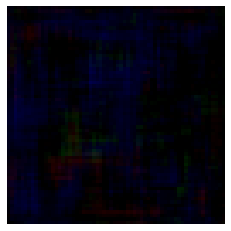

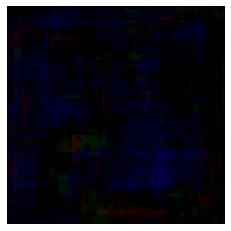

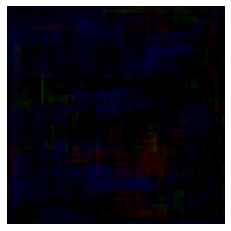

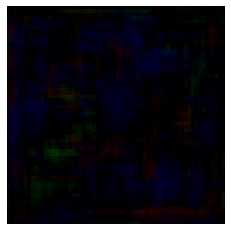

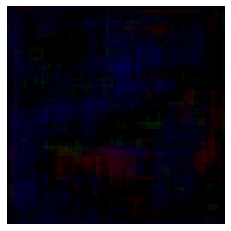

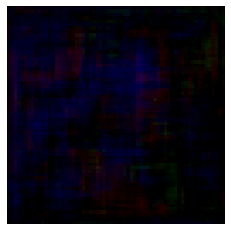

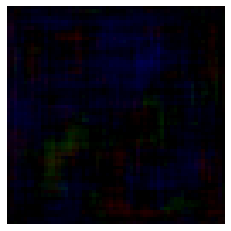

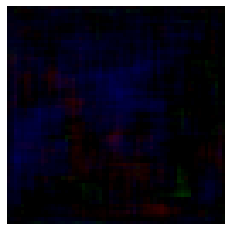

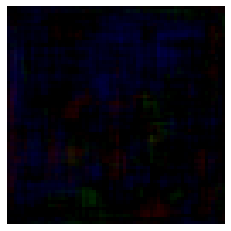

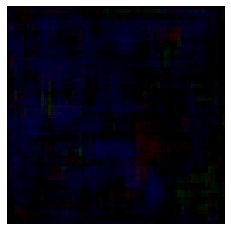

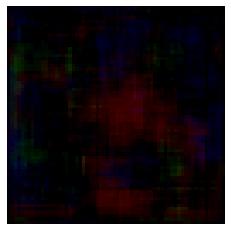

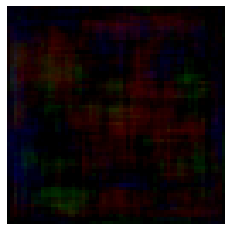

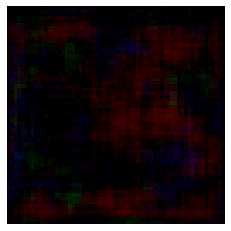

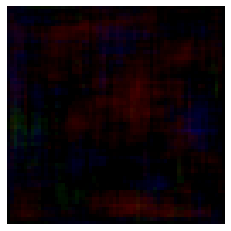

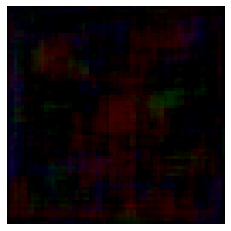

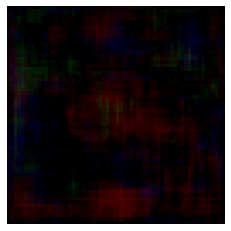

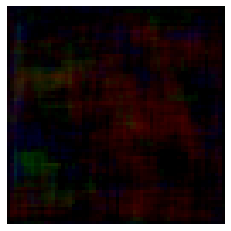

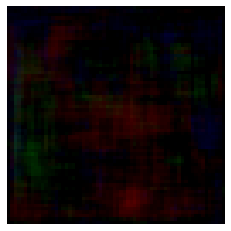

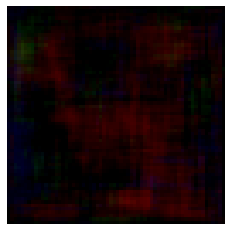

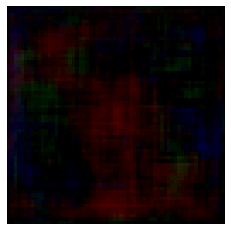

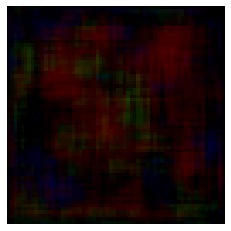

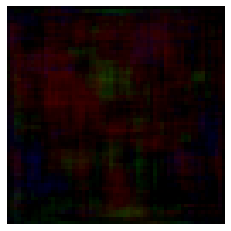

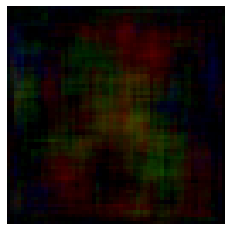

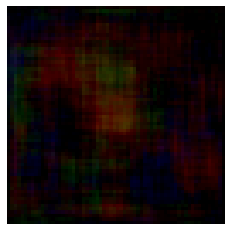

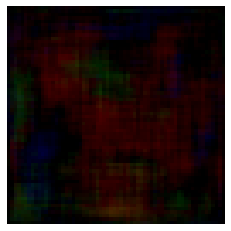

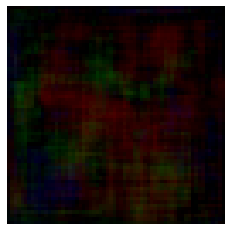

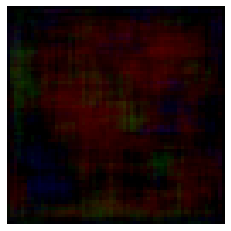

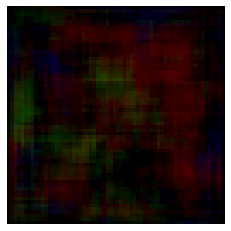

Error in callback <function flush_figures at 0x7f8d767c7950> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
stage1 = StackGanStage1()
stage1.train_stage1()

The above error came because the iteration was stopped after first epoch

In [ ]:
def concat_along_dims(inputs):

	
	c = inputs[0]
	x = inputs[1]

	c = K.expand_dims(c, axis=1)
	c = K.expand_dims(c, axis=1)
	c = K.tile(c, [1, 16, 16, 1])
	return K.concatenate([c, x], axis = 3)

def residual_block(input):
	"""Residual block with plain identity connections.

	Args:
		inputs: input layer or an encoded layer

	Returns:
		Layer with computed identity mapping.
	"""
	x = Conv2D(512, kernel_size=(3,3), padding='same', use_bias=False,
				kernel_initializer='he_uniform')(input)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)
	
	x = Conv2D(512, kernel_size=(3,3), padding='same', use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	
	x = add([x, input])
	x = ReLU()(x)

	return x

def build_stage2_generator():
	"""Build the Stage 2 Generator Network using the conditioning text and images from stage 1.

	Returns:
		Stage 2 Generator Model for StackGAN.
	"""
	input_layer1 = Input(shape=(1024,))
	input_images = Input(shape=(64, 64, 3))

	# Conditioning Augmentation
	ca = Dense(256)(input_layer1)
	mls = LeakyReLU(alpha=0.2)(ca)
	c = Lambda(conditioning_augmentation)(mls)

	# Downsampling block
	x = ZeroPadding2D(padding=(1,1))(input_images)
	x = Conv2D(128, kernel_size=(3,3), strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = ReLU()(x)

	x = ZeroPadding2D(padding=(1,1))(x)
	x = Conv2D(256, kernel_size=(4,4), strides=2, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	x = ZeroPadding2D(padding=(1,1))(x)
	x = Conv2D(512, kernel_size=(4,4), strides=2, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	# Concatenate text conditioning block with the encoded image
	concat = concat_along_dims([c, x])

	# Residual Blocks
	x = ZeroPadding2D(padding=(1,1))(concat)
	x = Conv2D(512, kernel_size=(3,3), use_bias=False, kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	x = residual_block(x)
	x = residual_block(x)
	x = residual_block(x)
	x = residual_block(x)

	# Upsampling Blocks
	x = UpSamplingBlock(x, 512)
	x = UpSamplingBlock(x, 256)
	x = UpSamplingBlock(x, 128)
	x = UpSamplingBlock(x, 64)

	x = Conv2D(3, kernel_size=(3,3), padding='same', use_bias=False, kernel_initializer='he_uniform')(x)
	x = Activation('tanh')(x)
	
	stage2_gen = Model(inputs=[input_layer1, input_images], outputs=[x, mls])
	return stage2_gen



In [ ]:
generator_stage2 = build_stage2_generator()
generator_stage2.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_59 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 66, 66, 3)   0           ['input_59[0][0]']               
                                                                                                  
 conv2d_70 (Conv2D)             (None, 64, 64, 128)  3456        ['zero_padding2d[0][0]']         
                                                                                                  
 re_lu_40 (ReLU)                (None, 64, 64, 128)  0           ['conv2d_70[0][0]']              
                                                                                           

In [ ]:
def build_stage2_discriminator():
	"""Builds the Stage 2 Discriminator that uses the 256x256 resolution images from the generator
	and the compressed and spatially replicated embeddings.

	Returns:
		Stage 2 Discriminator Model for StackGAN.
	"""
	input_layer1 = Input(shape=(256, 256, 3))

	x = Conv2D(64, kernel_size=(4,4), padding='same', strides=2, use_bias=False,
				kernel_initializer='he_uniform')(input_layer1)
	x = LeakyReLU(alpha=0.2)(x)

	x = ConvBlock(x, 128)
	x = ConvBlock(x, 256)
	x = ConvBlock(x, 512)
	x = ConvBlock(x, 1024)
	x = ConvBlock(x, 2048)
	x = ConvBlock(x, 1024, (1,1), 1)
	x = ConvBlock(x, 512, (1,1), 1, False)

	x1 = ConvBlock(x, 128, (1,1), 1)
	x1 = ConvBlock(x1, 128, (3,3), 1)
	x1 = ConvBlock(x1, 512, (3,3), 1, False)

	x2 = add([x, x1])
	x2 = LeakyReLU(alpha=0.2)(x2)

	# Concatenate compressed and spatially replicated embedding
	input_layer2 = Input(shape=(4, 4, 128))
	concat = concatenate([x2, input_layer2])

	x3 = Conv2D(512, kernel_size=(1,1), strides=1, padding='same', kernel_initializer='he_uniform')(concat)
	x3 = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x3)
	x3 = LeakyReLU(alpha=0.2)(x3)

	# Flatten and add a FC layer
	x3 = Flatten()(x3)
	x3 = Dense(1)(x3)
	x3 = Activation('sigmoid')(x3)

	stage2_dis = Model(inputs=[input_layer1, input_layer2], outputs=[x3])
	return stage2_dis



In [ ]:
discriminator_stage2 = build_stage2_discriminator()
discriminator_stage2.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_87 (Conv2D)             (None, 128, 128, 64  3072        ['input_60[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_48 (LeakyReLU)     (None, 128, 128, 64  0           ['conv2d_87[0][0]']              
                                )                                                          

In [ ]:

############################################################
# Stage 2 Adversarial Model
############################################################

def stage2_adversarial_network(stage2_disc, stage2_gen, stage1_gen):
	"""Stage 2 Adversarial Network.

	Args:
		stage2_disc: Stage 2 Discriminator Model.
		stage2_gen: Stage 2 Generator Model.
		stage1_gen: Stage 1 Generator Model.

	Returns:
		Stage 2 Adversarial network.
	"""
	conditioned_embedding = Input(shape=(1024, ))
	latent_space = Input(shape=(100, ))
	compressed_replicated = Input(shape=(4, 4, 128))
    
	#the discriminator is trained separately and stage1_gen alearning_rateeady trained, and this is the reason why we freeze its layers by setting the property trainable=false
	input_images, ca = stage1_gen([conditioned_embedding, latent_space])
	stage2_disc.trainable = False
	stage1_gen.trainable = False

	images, ca2 = stage2_gen([conditioned_embedding, input_images])
	probability = stage2_disc([images, compressed_replicated])

	return Model(inputs=[conditioned_embedding, latent_space, compressed_replicated],
		outputs=[probability, ca2])


In [ ]:
adversarial_stage2 = stage2_adversarial_network(discriminator_stage2, generator_stage2, generator)
adversarial_stage2.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_63 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 model (Functional)             [(None, 64, 64, 3),  10270400    ['input_62[0][0]',               
                                 (None, 256)]                     'input_63[0][0]']               
                                                                                                  
 model_30 (Functional)          [(None, 256, 256, 3  28645440    ['input_62[0][0]',        

In [ ]:

class StackGanStage2(object):
	"""StackGAN Stage 2 class.

	Args:
		epochs: Number of epochs
		z_dim: Latent space dimensions
		batch_size: Batch Size
		enable_function: If True, training function is decorated with tf.function
		stage2_generator_learning_rate: Learning rate for stage 2 generator
		stage2_discriminator_learning_rate: Learning rate for stage 2 discriminator
	"""
	def __init__(self, epochs=500, z_dim=100, batch_size=64, enable_function=True, stage2_generator_learning_rate=0.0002, stage2_discriminator_learning_rate=0.0002):
		self.epochs = epochs
		self.z_dim = z_dim
		self.enable_function = enable_function
		self.stage1_generator_learning_rate = stage2_generator_learning_rate
		self.stage1_discriminator_learning_rate = stage2_discriminator_learning_rate
		self.low_image_size = 64
		self.high_image_size = 256
		self.conditioning_dim = 128
		self.batch_size = batch_size
		self.stage2_generator_optimizer = Adam(learning_rate=stage2_generator_learning_rate, beta_1=0.5, beta_2=0.999)
		self.stage2_discriminator_optimizer = Adam(learning_rate=stage2_discriminator_learning_rate, beta_1=0.5, beta_2=0.999)
		self.stage1_generator = build_stage1_generator()
		self.stage1_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)
		self.stage1_generator.load_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage1_gen.h5')
		self.stage2_generator = build_stage2_generator()
		self.stage2_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)

		self.stage2_discriminator = build_stage2_discriminator()
		self.stage2_discriminator.compile(loss='binary_crossentropy', optimizer=self.stage2_discriminator_optimizer)

		self.ca_network = build_ca_network()
		self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')

		self.embedding_compressor = build_embedding_compressor()
		self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')

		self.stage2_adversarial = stage2_adversarial_network(self.stage2_discriminator, self.stage2_generator, self.stage1_generator)
		self.stage2_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], loss_weights=[1, 2.0], optimizer=self.stage2_generator_optimizer)	

		self.checkpoint2 = tf.train.Checkpoint(
        	generator_optimizer=self.stage2_generator_optimizer,
        	discriminator_optimizer=self.stage2_discriminator_optimizer,
        	generator=self.stage2_generator,
        	discriminator=self.stage2_discriminator,
        	generator1=self.stage1_generator)

	def visualize_stage2(self):
		"""Running Tensorboard visualizations.
		"""
		tb = TensorBoard(log_dir="logs/".format(time.time()))
		tb.set_model(self.stage2_generator)
		tb.set_model(self.stage2_discriminator)

	def train_stage2(self):
		"""Trains Stage 2 StackGAN.
		"""
		x_high_train, y_high_train, high_train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
      dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(256, 256))

		x_high_test, y_high_test, high_test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test, 
      dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(256, 256))

		x_low_train, y_low_train, low_train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
      dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(64, 64))

		x_low_test, y_low_test, low_test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test, 
      dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(64, 64))

		real = np.ones((self.batch_size, 1), dtype='float') * 0.9
		fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

		for epoch in range(self.epochs):
			print(f'Epoch: {epoch}')

			gen_loss = []
			disc_loss = []

			num_batches = int(x_high_train.shape[0] / self.batch_size)

			for i in range(num_batches):

				latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				embedding_text = high_train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
				compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
				compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, self.conditioning_dim))
				compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

				image_batch = x_high_train[i * self.batch_size:(i+1) * self.batch_size]
				image_batch = (image_batch - 127.5) / 127.5
				
				low_res_fakes, _ = self.stage1_generator.predict([embedding_text, latent_space], verbose=3)
				high_res_fakes, _ = self.stage2_generator.predict([embedding_text, low_res_fakes], verbose=3)

				discriminator_loss = self.stage2_discriminator.train_on_batch([image_batch, compressed_embedding],
					np.reshape(real, (self.batch_size, 1)))

				discriminator_loss_gen = self.stage2_discriminator.train_on_batch([high_res_fakes, compressed_embedding],
					np.reshape(fake, (self.batch_size, 1)))

				discriminator_loss_fake = self.stage2_discriminator.train_on_batch([image_batch[:(self.batch_size-1)], compressed_embedding[1:]],
					np.reshape(fake[1:], (self.batch_size - 1, 1)))

				d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_fake))
				disc_loss.append(d_loss)

				print(f'Discriminator Loss: {d_loss}')

				g_loss = self.stage2_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
					[K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])
				gen_loss.append(g_loss)

				print(f'Generator Loss: {g_loss}')

				if epoch % 5 == 0:
					latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
					embedding_batch = high_test_embeds[0 : self.batch_size]

					low_fake_images, _ = self.stage1_generator.predict([embedding_batch, latent_space], verbose=3)
					high_fake_images, _ = self.stage2_generator.predict([embedding_batch, low_fake_images], verbose=3)

					for i, image in enumerate(high_fake_images[:10]):
					    save_image(image, f'/content/drive/MyDrive/Colab Notebooks/images_/gen_{epoch}_{i}.png')

				if epoch % 10 == 0:
					self.stage2_generator.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage2_gen.h5')
					self.stage2_discriminator.save_weights("/content/drive/MyDrive/Colab Notebooks/weight/stage2_disc.h5")
					self.ca_network.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage2_ca.h5')
					self.embedding_compressor.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage2_embco.h5')
					self.stage2_adversarial.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage2_adv.h5')

		self.stage2_generator.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage2_gen.h5')
		self.stage2_discriminator.save_weights("/content/drive/MyDrive/Colab Notebooks/weight/stage2_disc.h5")


In [ ]:

class StackGanStage2(object):
	"""StackGAN Stage 2 class.

	Args:
		epochs: Number of epochs
		z_dim: Latent space dimensions
		batch_size: Batch Size
		enable_function: If True, training function is decorated with tf.function
		stage2_generator_learning_rate: Learning rate for stage 2 generator
		stage2_discriminator_learning_rate: Learning rate for stage 2 discriminator
	"""
	def __init__(self, epochs=10, z_dim=100, batch_size=64, enable_function=True, stage2_generator_learning_rate=0.0002, stage2_discriminator_learning_rate=0.0002):
		self.epochs = epochs
		self.z_dim = z_dim
		self.enable_function = enable_function
		self.stage1_generator_learning_rate = stage2_generator_learning_rate
		self.stage1_discriminator_learning_rate = stage2_discriminator_learning_rate
		self.low_image_size = 64
		self.high_image_size = 256
		self.conditioning_dim = 128
		self.batch_size = batch_size
		self.stage2_generator_optimizer = Adam(learning_rate=stage2_generator_learning_rate, beta_1=0.5, beta_2=0.999)
		self.stage2_discriminator_optimizer = Adam(learning_rate=stage2_discriminator_learning_rate, beta_1=0.5, beta_2=0.999)
		self.stage1_generator = build_stage1_generator()
		self.stage1_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)
		self.stage1_generator.load_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage1_gen.h5')
    #self.stage1_generator.close()
		self.stage2_generator = build_stage2_generator()
		self.stage2_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)

		self.stage2_discriminator = build_stage2_discriminator()
		self.stage2_discriminator.compile(loss='binary_crossentropy', optimizer=self.stage2_discriminator_optimizer)

		self.ca_network = build_ca_network()
		self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')

		self.embedding_compressor = build_embedding_compressor()
		self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')

		self.stage2_adversarial = stage2_adversarial_network(self.stage2_discriminator, self.stage2_generator, self.stage1_generator)
		self.stage2_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], loss_weights=[1, 2.0], optimizer=self.stage2_generator_optimizer)	

		self.checkpoint2 = tf.train.Checkpoint(
        	generator_optimizer=self.stage2_generator_optimizer,
        	discriminator_optimizer=self.stage2_discriminator_optimizer,
        	generator=self.stage2_generator,
        	discriminator=self.stage2_discriminator,
        	generator1=self.stage1_generator)

	def visualize_stage2(self):
		"""Running Tensorboard visualizations.
		"""
		tb = TensorBoard(log_dir="logs/".format(time.time()))
		tb.set_model(self.stage2_generator)
		tb.set_model(self.stage2_discriminator)

	def train_stage2(self):
		"""Trains Stage 2 StackGAN.
		"""
		x_high_train, y_high_train, high_train_embeds = load_data(filename_path='/content/drive/MyDrive/Colab Notebooks/birds/train/filenames.pickle', class_id_path='/content/drive/MyDrive/Colab Notebooks/birds/train/class_info.pickle',
      dataset_path="/content/drive/MyDrive/Colab Notebooks/CUB_200_2011", embeddings_path='/content/drive/MyDrive/Colab Notebooks/birds/train/char-CNN-RNN-embeddings.pickle', size=(256, 256))

		x_high_test, y_high_test, high_test_embeds = load_data(filename_path="/content/drive/MyDrive/Colab Notebooks/birds/test/filenames.pickle", class_id_path="/content/drive/MyDrive/Colab Notebooks/birds/test/class_info.pickle", 
      dataset_path="/content/drive/MyDrive/Colab Notebooks/CUB_200_2011", embeddings_path='/content/drive/MyDrive/Colab Notebooks/birds/test/char-CNN-RNN-embeddings.pickle', size=(256, 256))

		x_low_train, y_low_train, low_train_embeds = load_data(filename_path='/content/drive/MyDrive/Colab Notebooks/birds/train/filenames.pickle', class_id_path='/content/drive/MyDrive/Colab Notebooks/birds/train/class_info.pickle',
      dataset_path="/content/drive/MyDrive/Colab Notebooks/CUB_200_2011", embeddings_path='/content/drive/MyDrive/Colab Notebooks/birds/train/char-CNN-RNN-embeddings.pickle', size=(64, 64))

		x_low_test, y_low_test, low_test_embeds = load_data(filename_path="/content/drive/MyDrive/Colab Notebooks/birds/test/filenames.pickle", class_id_path="/content/drive/MyDrive/Colab Notebooks/birds/test/class_info.pickle", 
      dataset_path="/content/drive/MyDrive/Colab Notebooks/CUB_200_2011", embeddings_path='/content/drive/MyDrive/Colab Notebooks/birds/test/char-CNN-RNN-embeddings.pickle', size=(64, 64))
  

  	 
		real = np.ones((self.batch_size, 1), dtype='float') * 0.9
		fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

		for epoch in range(self.epochs):
			print(f'Epoch: {epoch}')

			gen_loss = []
			disc_loss = []

			num_batches = int(x_high_train.shape[0] / self.batch_size)

			for i in range(num_batches):

				latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				embedding_text = high_train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
				compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
				compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, self.conditioning_dim))
				compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

				image_batch = x_high_train[i * self.batch_size:(i+1) * self.batch_size]
				image_batch = (image_batch - 127.5) / 127.5
				
				low_res_fakes, _ = self.stage1_generator.predict([embedding_text, latent_space], verbose=3)
				high_res_fakes, _ = self.stage2_generator.predict([embedding_text, low_res_fakes], verbose=3)

				discriminator_loss = self.stage2_discriminator.train_on_batch([image_batch, compressed_embedding],
					np.reshape(real, (self.batch_size, 1)))

				discriminator_loss_gen = self.stage2_discriminator.train_on_batch([high_res_fakes, compressed_embedding],
					np.reshape(fake, (self.batch_size, 1)))

				discriminator_loss_fake = self.stage2_discriminator.train_on_batch([image_batch[:(self.batch_size-1)], compressed_embedding[1:]],
					np.reshape(fake[1:], (self.batch_size - 1, 1)))

				d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_fake))
				disc_loss.append(d_loss)

				print(f'Discriminator Loss: {d_loss}')

				g_loss = self.stage2_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
					[K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])
				gen_loss.append(g_loss)

				print(f'Generator Loss: {g_loss}')

				if epoch % 5 == 0:
					latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
					embedding_batch = high_test_embeds[0 : self.batch_size]

					low_fake_images, _ = self.stage1_generator.predict([embedding_batch, latent_space], verbose=3)
					high_fake_images, _ = self.stage2_generator.predict([embedding_batch, low_fake_images], verbose=3)

					for i, image in enumerate(high_fake_images[:10]):
					    save_image(image, f'/content/drive/MyDrive/Colab Notebooks/images_/gen_{epoch}_{i}.png')

				if epoch % 10 == 0:
					self.stage2_generator.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage2_gen.h5')
					self.stage2_discriminator.save_weights("/content/drive/MyDrive/Colab Notebooks/weight/stage2_disc.h5")
					self.ca_network.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage2_ca.h5')
					self.embedding_compressor.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage2_embco.h5')
					self.stage2_adversarial.save_weights('/content/drive/MyDrive/Colab Notebooks/weight/stage2_adv.h5')

		self.stage2_generator.save_weights('/content/drive/MyDrive/Colab Notebooks/weight2/stage2_gen.h5')
		self.stage2_discriminator.save_weights("/content/drive/MyDrive/Colab Notebooks/weight2/stage2_disc.h5")


In [ ]:
stage2 = StackGanStage2()
stage2.train_stage2()

Epoch: 0
Discriminator Loss: 4.66571569442749
